**Task**

Binary Classification - Do an exploratory analysis of the dataset provided, decide on feature selection, preprocessing before training a model to classify as class ‘0’ or class ‘1’.


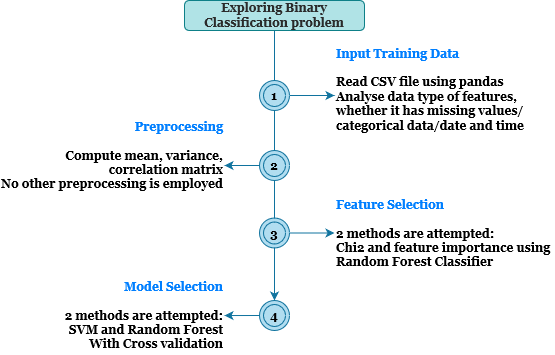

First step to access the data: 

Upload the files or sync the google drive

In [1]:
import os
os.chdir('/content/drive/My Drive/arya/')
!ls

 arya					 bin_classify.ipynb   train.csv
'Assignment - Data Scientist (1).docx'	 test.csv


**Include all library imports here**

In [2]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.ensemble import RandomForestClassifier# instantiate model
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,train_test_split
from mlxtend.plotting import plot_confusion_matrix



**Data Analysis:**

Check whether the columns are all numerical or categorical.

Use the info command to know the data type and size etc.


In [3]:
# Read the csv files for training and testing purposes
train_df = pd.read_csv('train.csv',index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)#    ,skiprows=1)

feature_names = pd.read_csv('train.csv', index_col=0, nrows=0).columns.tolist()
print(len(feature_names),feature_names)
#train_df.info()
#train_df = train_df.dropna(thresh=20,axis=1) # It is observed that there are no NA values in the excel sheet.
##However, in case there are any missing values we can address it by replacing it with mean value. 
## There are 57 features. 55 of them are float and 3 are int, label is also int. 
## convert all to same format - float numpy array

58 ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'Y']


In [4]:
feature_names.remove('Y')
print(len(feature_names), feature_names)

57 ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57']


In [5]:
# there are no categorical data or missing data. 
## No column is corresponding to date and time. 
## column X54 has bigger range compared to other columns , therefore, normalization might be necessary.
## Separate the features and label from dataset. 
X = train_df.iloc[:, :-1] ## dataframe with header
y = train_df.iloc[:, -1]  ## data frame without header
x_data = train_df.iloc[1:, :-1].values # numpy
y_data = train_df.iloc[1:, -1].values  # numpy
test_data = test_df.to_numpy()
print(X.shape, y.shape, x_data.shape, y_data.shape, test_data.shape)

(3910, 57) (3910,) (3909, 57) (3909,) (691, 57)


The features may  be independent or correlated to each other. 

Perform Correlation analysis to find out whether redundant features exist.

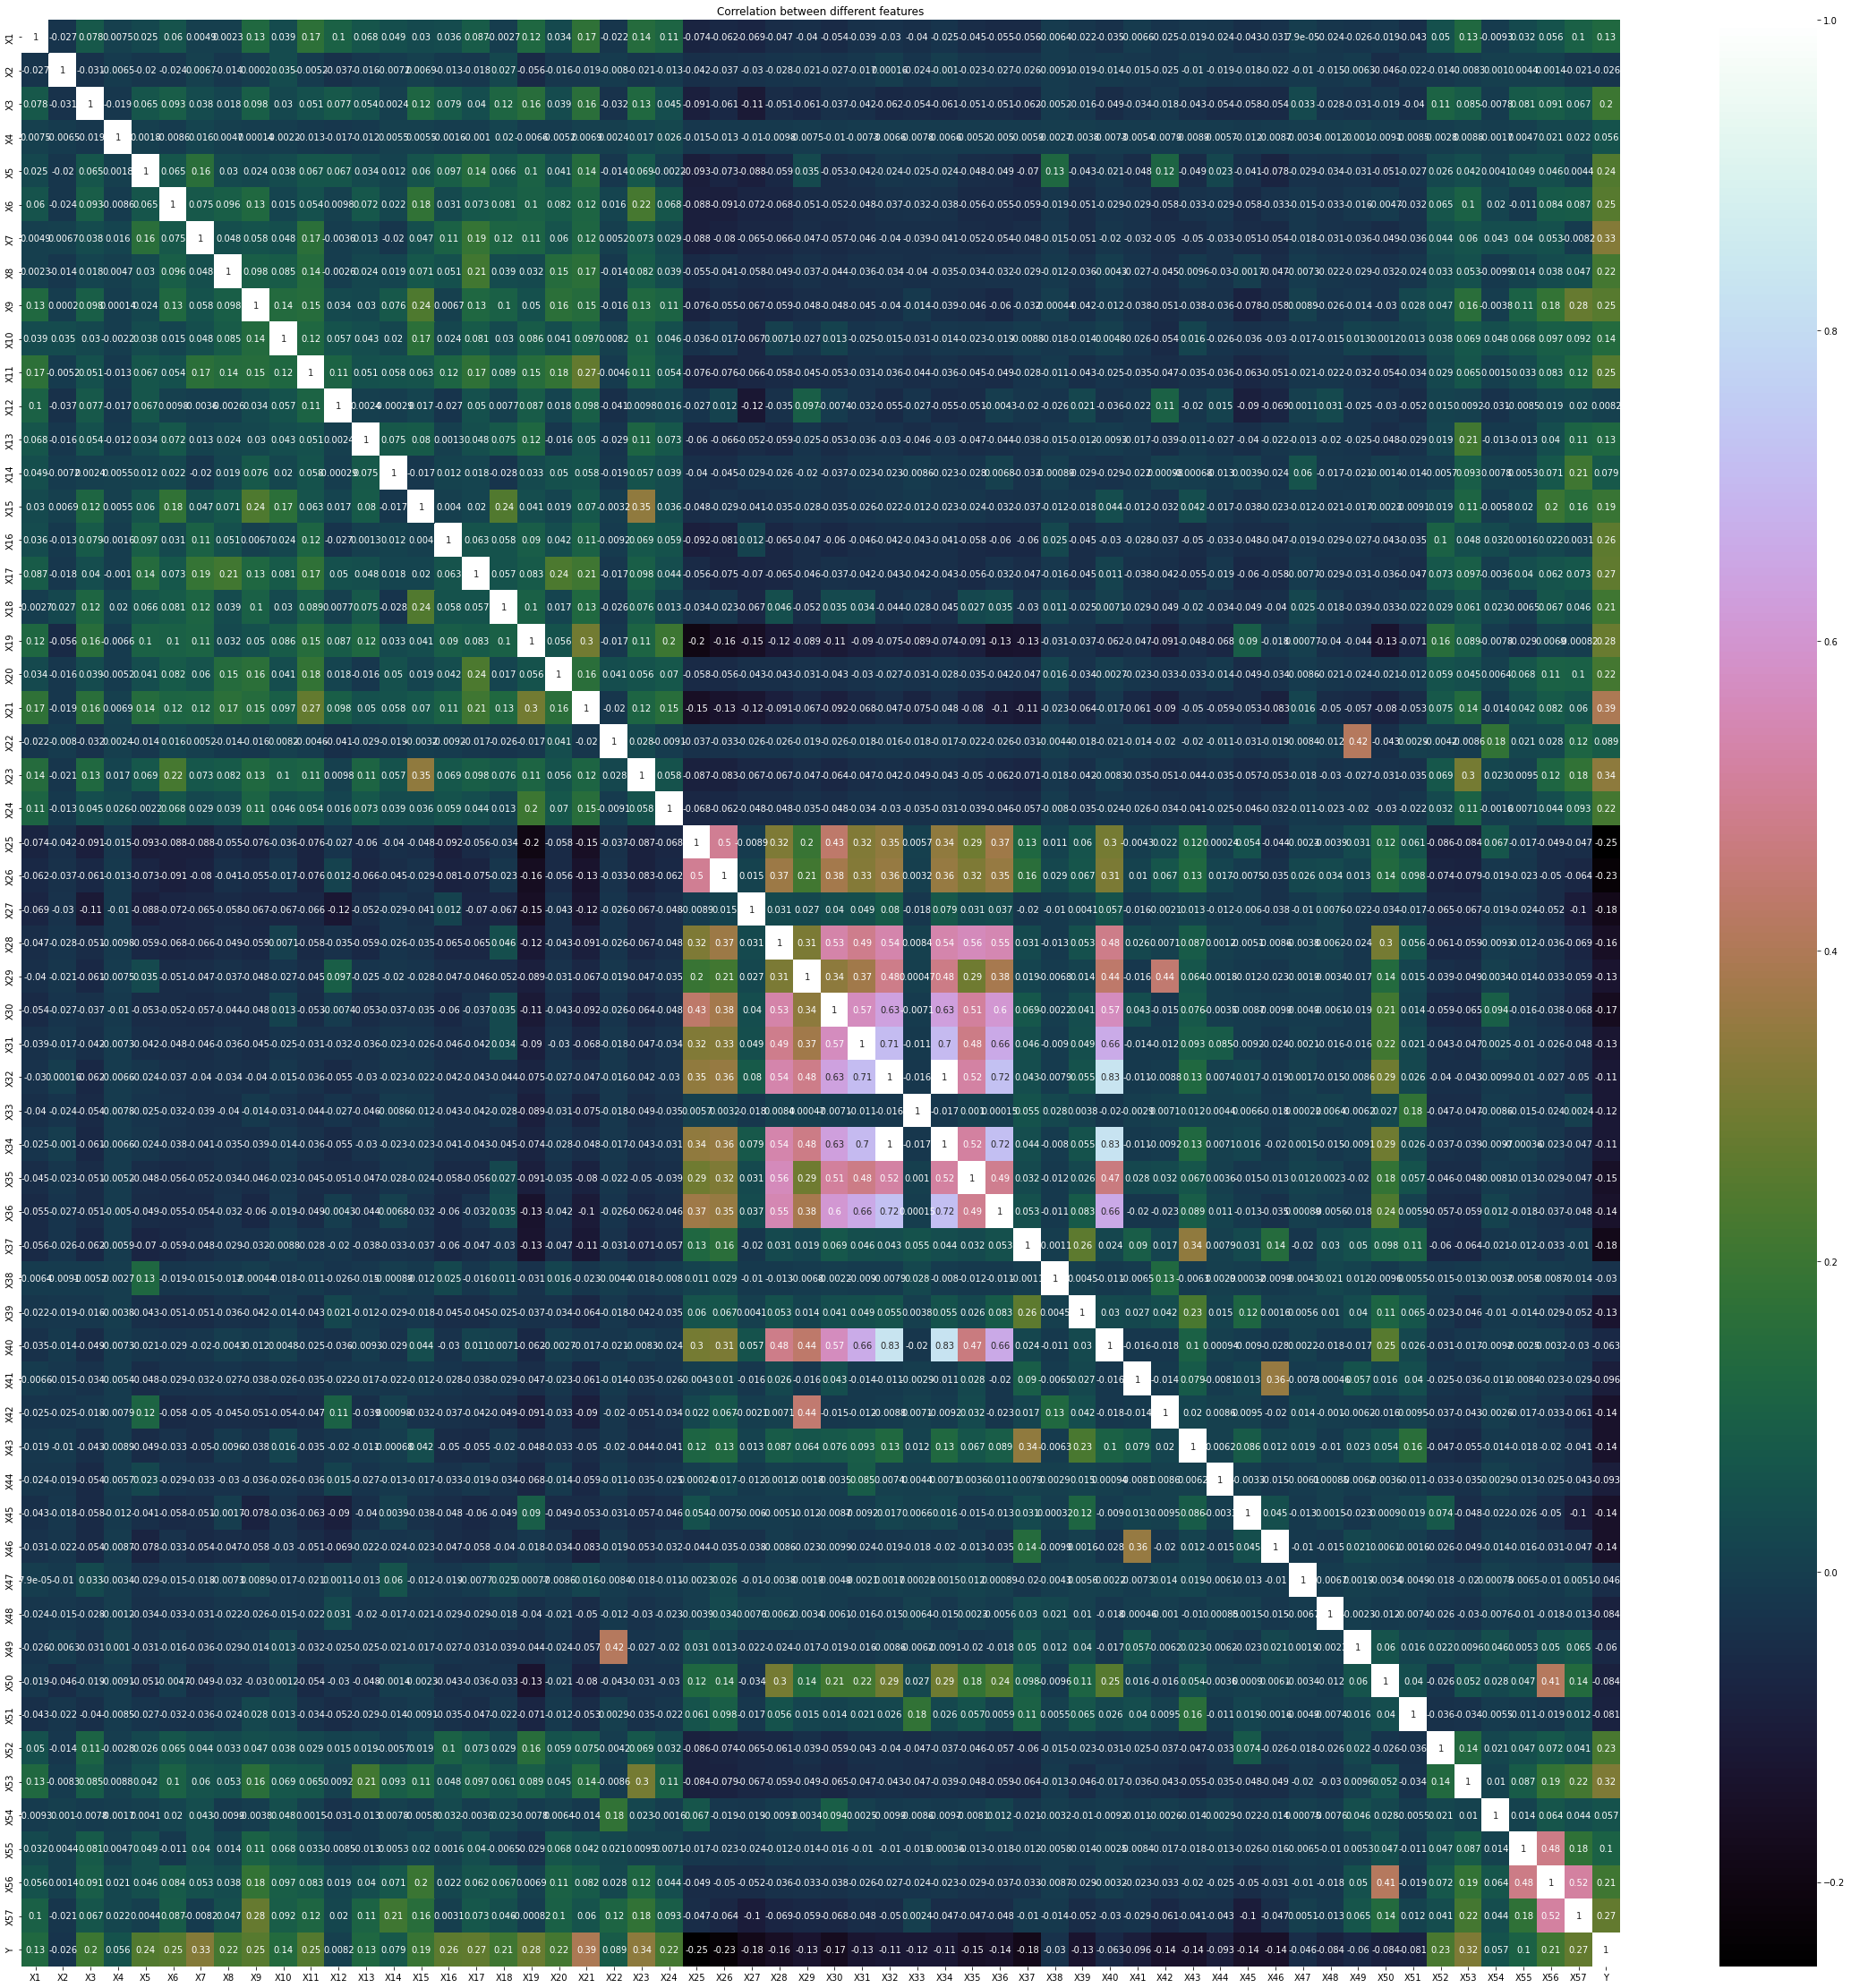

In [6]:
correlation = train_df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation,annot=True,cmap='cubehelix')
plt.title('Correlation between different features');
## most of them are not strongly correlated. They are independent. 
## No clarity on feature reduction. 
## feature transformation using PCA is another option. 

In [7]:
#print("Variance of each feature\n",train_df.var(),"\n\nMean of each feature\n",train_df.mean())
#pd.plotting.scatter_matrix(train_df);

If necessary normalize the dataset.

In [8]:
sc_X = StandardScaler()
x_data_normal = sc_X.fit_transform(x_data)
test_data_normal = sc_X.transform(test_data)

Just check whether dimensionality reduction can be useful


 The explained variance ratio  [0.11225959 0.05770238 0.03587979 0.0282377  0.02658256 0.02561033
 0.02460085 0.02402168 0.02277391 0.02209312] 




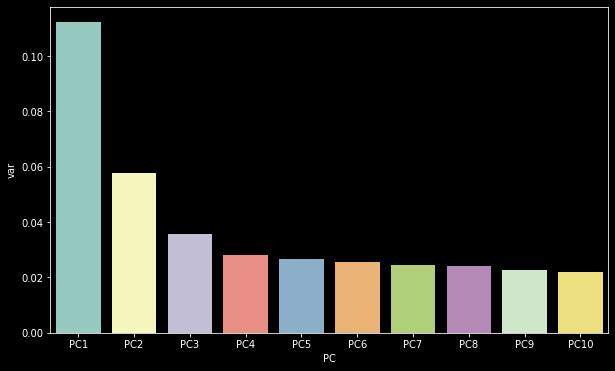

In [9]:
pca = PCA(n_components=10)  ## must be <= number of features in the data.
X_r = pca.fit(x_data_normal).transform(x_data_normal) ## fit command automatically obtains the eigen values of cov matrix of data. 
## transform is to obtain the transformed values of original features , we can use only fit, to obtain the principal components.

with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 6))
    df_new = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4', 'PC5', 'PC6','PC7','PC8','PC9','PC10']})
    sns.barplot(x='PC',y='var', data=df_new);

print("\n The explained variance ratio ", pca.explained_variance_ratio_, "\n\n")

Select features using Chi2 test.

Chi2 is usually used for categorical data.

In [10]:
bestfeatures = SelectKBest(score_func=chi2, k=25)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(25,'Score'))  #print 10 best features

   Specs          Score
56   X57  337782.325728
55   X56  134374.683058
54   X55    8391.552326
26   X27    1902.026070
24   X25    1343.216006
20   X21    1080.955195
15   X16     710.305054
25   X26     626.389608
18   X19     587.874592
6     X7     565.424535
51   X52     538.716701
22   X23     530.050513
19   X20     426.423868
45   X46     401.648458
23   X24     391.796244
16   X17     391.384341
3     X4     365.151653
41   X42     338.726296
52   X53     334.177788
4     X5     317.691556
44   X45     289.820883
7     X8     276.770266
21   X22     268.586752
17   X18     249.799938
28   X29     249.507458


Obtain the reduced feature set

In [11]:
X_train_fs = bestfeatures.transform(X)
X_test_fs = bestfeatures.transform(test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  "X does not have valid feature names, but"


In [12]:
print(X.shape, X_train_fs.shape,X_test_fs.shape)

(3910, 57) (3910, 25) (691, 25)


Just to verify take another feature selection method using random forect classifier

In [13]:
model = RandomForestClassifier(n_estimators=200, random_state=0)# fit model
model.fit(X,y)
importances = model.feature_importances_
print(importances.shape,sorted(importances,reverse=True))

(57,) [0.11505575705786696, 0.08866967709053668, 0.08225683762157728, 0.06987436922476196, 0.061929349891497044, 0.058941925509914624, 0.054660937910324614, 0.04444768431102922, 0.043516778033252435, 0.04196779889079149, 0.0325730098147274, 0.031031567675142094, 0.024996713167163277, 0.01912233592677537, 0.019092253280082676, 0.01708970564093671, 0.014942049146144953, 0.013516331828121796, 0.012357740543884912, 0.012015780214091396, 0.011220233266261306, 0.011075237734893937, 0.009780711693331744, 0.009086208470496756, 0.008578273867956095, 0.00733760313343975, 0.006618344488847071, 0.005439879296460899, 0.005420642173655851, 0.005169332599802013, 0.004911867090796221, 0.004479598411558532, 0.0039541321715951955, 0.0037568751904678553, 0.0036325973390320915, 0.003605666007069662, 0.003436962703222192, 0.0032158289225097366, 0.003025095446762942, 0.0029510496675800757, 0.0027269624063878672, 0.0023160355116430354, 0.0022104816104675175, 0.0020580730685221026, 0.0020309895055956244, 0.00

In [14]:
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X)
select_X_test = selection.transform(test_data)
print(select_X_train.shape,select_X_test.shape)

(3910, 22) (691, 22)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


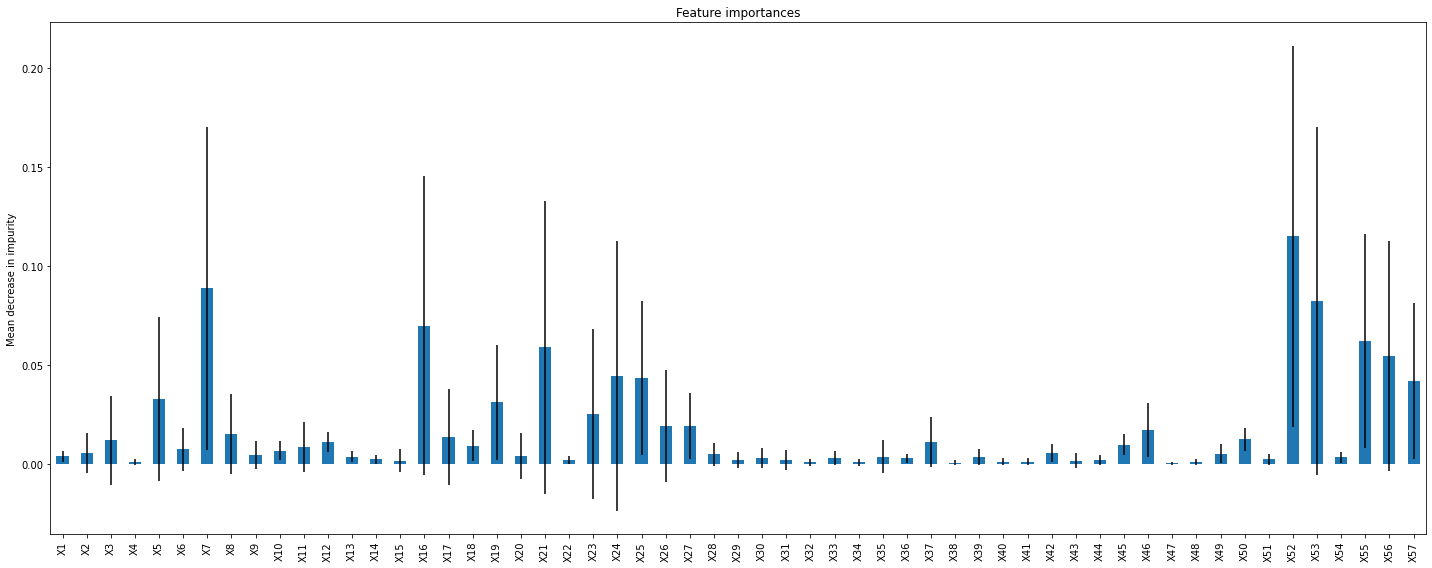

In [15]:
std = np.std([i.feature_importances_ for i in model.estimators_], axis=0)
feat_with_importance  = pd.Series(importances, index = feature_names)
fig, ax = plt.subplots(figsize = (20,8))
feat_with_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [16]:
'''
from sklearn.inspection import permutation_importance
result = permutation_importance(model, x_data, y_data, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots(figsize = (20,8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
'''

'\nfrom sklearn.inspection import permutation_importance\nresult = permutation_importance(model, x_data, y_data, n_repeats=10, random_state=42, n_jobs=2)\nforest_importances = pd.Series(result.importances_mean, index=feature_names)\nfig, ax = plt.subplots(figsize = (20,8))\nforest_importances.plot.bar(yerr=result.importances_std, ax=ax)\nax.set_title("Feature importances using permutation on full model")\nax.set_ylabel("Mean accuracy decrease")\nfig.tight_layout()\nplt.show()\n'

In [17]:
print("Shapes again:", X_train_fs.shape,select_X_train.shape,x_data.shape, y.shape) # chi2, random, original,labels

Shapes again: (3910, 25) (3910, 22) (3909, 57) (3910,)


Split the dataset for training and validation in the ratio 4:1

In [18]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(X_train_fs,y,test_size=0.25,random_state=3,  stratify=y)
x_train2, x_val2, y_train2, y_val2 = train_test_split(select_X_train,y,test_size=0.25,random_state=3,  stratify=y)
print(len(x_train1), len(x_val1), len(y_train1), len(y_val1))

2932 978 2932 978


In [19]:
def print_results(predicted_y,actual_y):
    print('Accuracy Score:')
    print(metrics.accuracy_score(actual_y,predicted_y))
    cm = confusion_matrix(actual_y,predicted_y)
    print(cm)
    print(classification_report(actual_y,predicted_y, target_names=['0','1']))
    fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True,figsize=(3,3))
    plt.show()

Apply SVM Classifier

Cross validation scores on features selected using chi2 [0.7120954  0.70698467 0.68088737 0.68259386 0.73549488]
Accuracy Score:
0.7055214723926381
[[518  76]
 [212 172]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       594
           1       0.69      0.45      0.54       384

    accuracy                           0.71       978
   macro avg       0.70      0.66      0.66       978
weighted avg       0.70      0.71      0.69       978



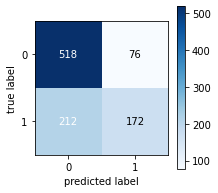

In [20]:
svc=SVC(kernel='rbf')  ### kernel = 'rbf' 'linear' 'poly'
svc.fit(x_train1,y_train1)
y_pred=svc.predict(x_val1)
scores = cross_val_score(svc, x_train1, y_train1, cv=5, scoring='accuracy') #cv is cross validation
print("Cross validation scores on features selected using chi2",scores)
print_results(y_pred,y_val1)

Cross validation scores on features selected using feature selector [0.7120954  0.70698467 0.68088737 0.68259386 0.73549488]
Accuracy Score:
0.7055214723926381
[[518  76]
 [212 172]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       594
           1       0.69      0.45      0.54       384

    accuracy                           0.71       978
   macro avg       0.70      0.66      0.66       978
weighted avg       0.70      0.71      0.69       978



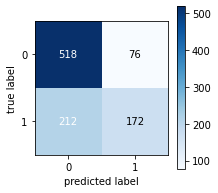

In [21]:
svc=SVC(kernel='rbf')  ### kernel = 'rbf' 'linear' 'poly'
svc.fit(x_train2,y_train2)
y_pred2=svc.predict(x_val2)
scores = cross_val_score(svc, x_train2, y_train2, cv=5, scoring='accuracy') #cv is cross validation
print("Cross validation scores on features selected using feature selector",scores)
print_results(y_pred2,y_val2)

Apply Random Forest (ensemble method) Classifier

Cross validation scores on features selected using Chi2 [0.95570698 0.93526405 0.94027304 0.93515358 0.94539249]
Accuracy Score:
0.9550102249488752
[[578  16]
 [ 28 356]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       594
           1       0.96      0.93      0.94       384

    accuracy                           0.96       978
   macro avg       0.96      0.95      0.95       978
weighted avg       0.96      0.96      0.95       978



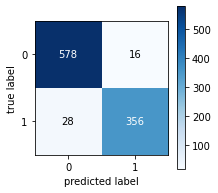

In [22]:
model = RandomForestClassifier(n_estimators=200, random_state=0)# fit model
model.fit(x_train1,y_train1)
y_pred3=model.predict(x_val1)
scores = cross_val_score(model, x_train1, y_train1, cv=5, scoring='accuracy') #cv is cross validation
print("Cross validation scores on features selected using Chi2",scores)
print_results(y_pred3,y_val1)

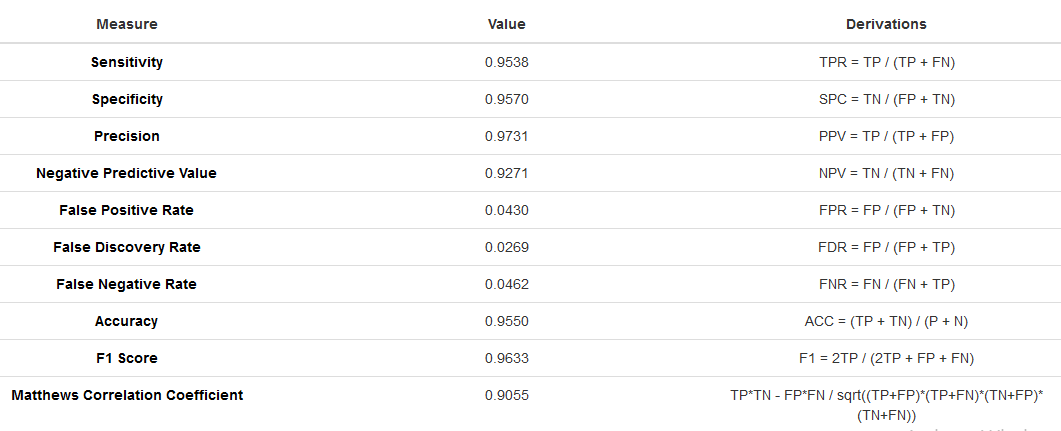

Cross validation scores on features selected using Chi2 [0.95400341 0.93015332 0.94027304 0.94197952 0.94197952]
Accuracy Score:
0.9498977505112475
[[577  17]
 [ 32 352]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       594
           1       0.95      0.92      0.93       384

    accuracy                           0.95       978
   macro avg       0.95      0.94      0.95       978
weighted avg       0.95      0.95      0.95       978



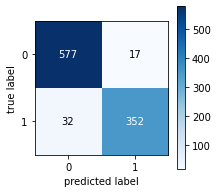

In [23]:
model2 = RandomForestClassifier(n_estimators=200, random_state=0)# fit model
model2.fit(x_train2,y_train2)
y_pred4=model2.predict(x_val2)
scores = cross_val_score(model2, x_train2, y_train2, cv=5, scoring='accuracy') #cv is cross validation
print("Cross validation scores on features selected using Chi2",scores)
print_results(y_pred4,y_val2)

From Confusion matrix, it is clear that, the feature selection using Chi2 test and Random classifier can give an accuracy of upto 95%. So use this as the final model to test the output. (test data)

In [24]:
predictions = model.predict(X_test_fs)
print(predictions)

[0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1
 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0
 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0
 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0
 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0
 0 1 0 0 0 0 0 0 0 0 1 0 